In [10]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report


In [11]:
batch_size = 32
img_height = 224
img_width = 224

In [12]:
data_dir = 'Food Classification'
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6269 files belonging to 20 classes.
Using 5016 files for training.


In [13]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds

Found 6269 files belonging to 20 classes.
Using 1253 files for validation.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [14]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)
test_ds

Found 6269 files belonging to 20 classes.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [15]:
class_names = train_ds.class_names
print(class_names)

['burger', 'butter_naan', 'chai', 'chapati', 'chole_bhature', 'dal_makhani', 'dhokla', 'fried_rice', 'idli', 'jalebi', 'kaathi_rolls', 'kadai_paneer', 'kulfi', 'masala_dosa', 'momos', 'paani_puri', 'pakode', 'pav_bhaji', 'pizza', 'samosa']


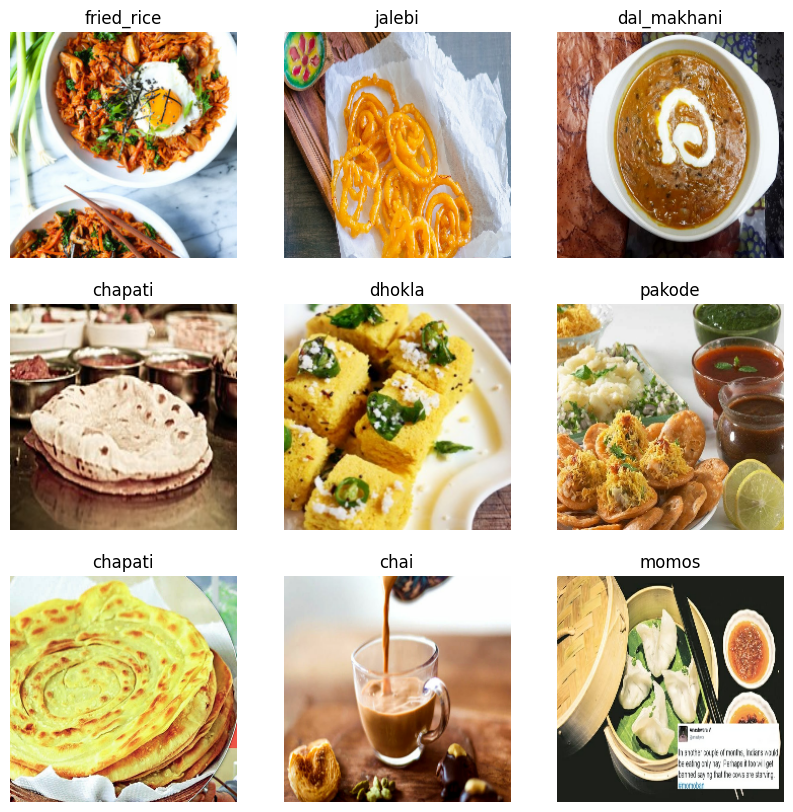

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [17]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [18]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [19]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9998097


In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [21]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# Load the MobileNetV2 model pre-trained on ImageNet, excluding the top classification layers
pretrained_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

# Unfreeze some layers in the pre-trained model
for layer in pretrained_model.layers[-20:]:  # Unfreeze the last 20 layers
    layer.trainable = True

# Build the model
inputs = pretrained_model.input

x = layers.Dense(256, activation='relu')(pretrained_model.output)
x = layers.Dropout(0.5)(x)  # Add dropout for regularization
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)  # Add another dropout layer
outputs = layers.Dense(20, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
print(model.summary())

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)









Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [22]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Stop if no improvement after 5 epochs
    restore_best_weights=True
)

In [23]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,  # You can set this to a higher number since early stopping will prevent overfitting
    callbacks=[early_stopping]
)

Epoch 1/50


157/157 [==============================] - 160s 846ms/step - loss: 2.7768 - accuracy: 0.1768 - val_loss: 2.4214 - val_accuracy: 0.2745
Epoch 2/50
157/157 [==============================] - 136s 863ms/step - loss: 1.7251 - accuracy: 0.4996 - val_loss: 1.5724 - val_accuracy: 0.5539
Epoch 3/50
157/157 [==============================] - 261s 2s/step - loss: 1.0658 - accuracy: 0.6990 - val_loss: 1.0774 - val_accuracy: 0.7151
Epoch 4/50
157/157 [==============================] - 158s 1s/step - loss: 0.7042 - accuracy: 0.7978 - val_loss: 0.9403 - val_accuracy: 0.7614
Epoch 5/50
157/157 [==============================] - 240s 2s/step - loss: 0.4872 - accuracy: 0.8640 - val_loss: 0.8339 - val_accuracy: 0.7885
Epoch 6/50
157/157 [==============================] - 256s 2s/step - loss: 0.3169 - accuracy: 0.9137 - val_loss: 0.8204 - val_accuracy: 0.8061
Epoch 7/50
157/157 [==============================] - 254s 2s/step - loss: 0.2336 - accuracy: 0.9302 - val_loss: 0.7202 - val_accuracy

In [24]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


196/196 [==============================] - 65s 310ms/step - loss: 0.3149 - accuracy: 0.9167
Test Loss: 0.3149
Test Accuracy: 91.67%


In [25]:
import pickle


with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)


In [32]:
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image
import numpy as np
from tensorflow.keras.models import load_model

with open('model.pkl', 'rb') as file:
    model = pickle.load(file)

# Load and preprocess the image

image = Image.open('images.jpeg')
image = image.resize((224, 224))  # Resize to match model input size
image = img_to_array(image)  # Convert to array
image = np.expand_dims(image, axis=0)  # Add batch dimension
image = image / 255.0  # Normalize pixel values to [0, 1]

# Debugging: Print shape and first few values of the preprocessed image
print(f"Image shape: {image.shape}")
print(f"First few values of the image array: {image.flatten()[:30]}")

# Get predictions
predictions = model.predict(image)

# Determine the predicted class
print(np.argmax(predictions))
predicted_class = np.argmax(predictions)
print(class_names[predicted_class])


Image shape: (1, 224, 224, 3)
First few values of the image array: [0.73333335 0.6862745  0.6313726  0.73333335 0.6862745  0.6313726
 0.7294118  0.68235296 0.627451   0.7254902  0.6745098  0.61960787
 0.72156864 0.6666667  0.6156863  0.7176471  0.6666667  0.6039216
 0.7137255  0.6627451  0.6        0.72156864 0.65882355 0.59607846
 0.72156864 0.65882355 0.59607846 0.7254902  0.65882355 0.59607846]
1/1 [==============================] - 1s 1s/step
16
pakode
